# **Merküt - Destan Doğal Dil İşleme Takımı**
---
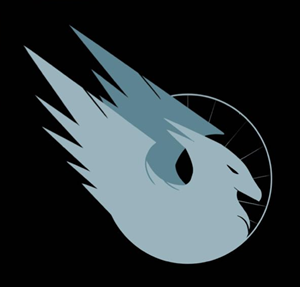

**A100 High-RAM:** *45 Epoch ~ 10 Compute Unit*

**Fine-Tuning Kodları**



```
# Donanım Kontrolü
```



In [ ]:
!nvidia-smi

Thu Mar 27 13:18:04 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   36C    P0             48W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----



```
# Google Drive ve virtualenv Entegrasyonu
```



In [ ]:
from google.colab import drive
drive.mount("/content/drive")
!pip install virtualenv
!virtualenv /content/drive/MyDrive/merkut_llm_2025/colab_virtual_env_v1

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
created virtual environment CPython3.11.11.final.0-64 in 7771ms
  creator CPython3Posix(dest=/content/drive/MyDrive/merkut_llm_2025/colab_virtual_env_v1, clear=False, no_vcs_ignore=False, global=False)
  seeder FromAppData(download=False, pip=bundle, setuptools=bundle, wheel=bundle, via=copy, app_data_dir=/root/.local/share/virtualenv)
    added seed packages: PyYAML==6.0.2, aiohappyeyeballs==2.6.1, aiohttp==3.11.14, aiosignal==1.3.2, attrs==25.3.0, certifi==2025.1.31, charset_normalizer==3.4.1, datasets==3.4.1, dill==0.3.8, filelock==3.18.0, frozenlist==1.5.0, fsspec==2024.12.0, huggingface_hub==0.29.3, idna==3.10, multidict==6.2.0, multiprocess==0.70.16, numpy==2.2.4, packaging==24.2, pandas==2.2.3, pip==25.0.1, propcache==0.3.1, pyarrow==19.0.1, python_dateutil==2.9.0.post0, pytz==2025.2, regex==2024.11.6, requests==2.32.3, safetensors==0.5.3, setuptools==



```
# virtualenv ile yüklenecek kütüphaneler
```



In [ ]:
!source /content/drive/MyDrive/merkut_llm_2025/colab_virtual_env_v1/bin/activate; pip install datasets
!source /content/drive/MyDrive/merkut_llm_2025/colab_virtual_env_v1/bin/activate; pip install transformers
!source /content/drive/MyDrive/merkut_llm_2025/colab_virtual_env_v1/bin/activate; pip install multiprocess
!source /content/drive/MyDrive/merkut_llm_2025/colab_virtual_env_v1/bin/activate; pip install dill==0.3.6

/bin/bash: /content/drive/MyDrive/merkut_llm_2025/colab_virtual_env_v1/bin/pip: /content/drive/MyDrive/merkut_llm_2025/colab_virtual_env_v1/bin/python: bad interpreter: Permission denied
/bin/bash: /content/drive/MyDrive/merkut_llm_2025/colab_virtual_env_v1/bin/pip: /content/drive/MyDrive/merkut_llm_2025/colab_virtual_env_v1/bin/python: bad interpreter: Permission denied
/bin/bash: /content/drive/MyDrive/merkut_llm_2025/colab_virtual_env_v1/bin/pip: /content/drive/MyDrive/merkut_llm_2025/colab_virtual_env_v1/bin/python: bad interpreter: Permission denied
/bin/bash: /content/drive/MyDrive/merkut_llm_2025/colab_virtual_env_v1/bin/pip: /content/drive/MyDrive/merkut_llm_2025/colab_virtual_env_v1/bin/python: bad interpreter: Permission denied




```
# virtualenv'deki kütüphaneleri projemize aktarıyoruz
```



In [ ]:
import sys
sys.path.append("/content/drive/MyDrive/merkut_llm_2025/colab_virtual_env_v1/lib/python3.11/site-packages")

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding
from datasets import Dataset
import pandas as pd
import torch
import os, re

In [ ]:
print("Başlangıç: Donanım kontrolü yapılıyor...")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Kullanılan cihaz: {device}")
if device.type == "cuda":
    print("CUDA Mevcut:", torch.cuda.is_available())
    print(f"CUDA Cihazı: {torch.cuda.get_device_name(0)}")
    print("CUDA Versiyonu:", torch.version.cuda)
    print("cuDNN Versiyonu:", torch.backends.cudnn.version())

Başlangıç: Donanım kontrolü yapılıyor...
Kullanılan cihaz: cuda
CUDA Mevcut: True
CUDA Cihazı: NVIDIA A100-SXM4-40GB
CUDA Versiyonu: 12.4
cuDNN Versiyonu: 90300


In [ ]:
raw_dataset_path = "/content/drive/MyDrive/merkut_llm_2025/llm_datasets/merged_dataset.csv"
cleaned_dataset_path = "/content/drive/MyDrive/merkut_llm_2025/llm_datasets/merged_dataset_cleaned.csv"
pretrained_model_path = "/content/drive/MyDrive/merkut_llm_2025/bert_finetuned_v2"  # Önceden eğitilmiş model yolu
checkpoint_path = "/content/drive/MyDrive/merkut_llm_2025/results_v6/checkpoint-1860/checkpoint-2790"

In [ ]:
print("Veri seti temizleniyor...")
if not os.path.exists(cleaned_dataset_path):
    df = pd.read_csv(raw_dataset_path, delimiter="|")
    df_cleaned = df.dropna(subset=["target", "text"])
    df_cleaned = df_cleaned[df_cleaned["target"].isin(["INSULT", "RACIST", "SEXIST", "PROFANITY", "OTHER"])]
    df_cleaned.to_csv(cleaned_dataset_path, index=False, sep="|")
    print("Veri seti temizlendi ve kaydedildi.")
else:
    print("Temizlenmiş veri seti mevcut.")

Veri seti temizleniyor...
Temizlenmiş veri seti mevcut.


In [ ]:
print("Veri seti yükleniyor...")
df = pd.read_csv(cleaned_dataset_path, delimiter="|")
print(f"Toplam {len(df)} satır veri bulundu.")

dataset = Dataset.from_pandas(df)

Veri seti yükleniyor...
Toplam 13252 satır veri bulundu.


In [ ]:
print("Model ve tokenizer yükleniyor...")
model = AutoModelForSequenceClassification.from_pretrained(checkpoint_path, num_labels=5, torch_dtype=torch.bfloat16).to(device)
model.gradient_checkpointing_enable()
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_path) #

Model ve tokenizer yükleniyor...


In [ ]:
print("Veri seti tokenleştiriliyor...")
def preprocess_function(examples):
    encoding = tokenizer(
        examples["text"],
        truncation=True,
        padding="max_length",
        max_length=512,
        return_tensors="pt" # Pytorch tensor
    )
    return {
        "input_ids": encoding["input_ids"],
        "attention_mask": encoding["attention_mask"]
    }

Veri seti tokenleştiriliyor...


In [ ]:
tokenized_datasets = dataset.map(preprocess_function, batched=True, remove_columns=["text"])

Map:   0%|          | 0/13252 [00:00<?, ? examples/s]

In [ ]:
label_mapping = {
    "INSULT": 0,
    "RACIST": 1,
    "SEXIST": 2,
    "PROFANITY": 3,
    "OTHER": 4
}

In [ ]:
def preprocess_labels(examples):
    examples["labels"] = [label_mapping[label.upper()] for label in examples["target"]]
    return examples

In [ ]:
tokenized_datasets = tokenized_datasets.map(preprocess_labels, batched=True, remove_columns=["target"])
print("Tokenizasyon ve etiket dönüştürme tamamlandı.")
tokenized_datasets = tokenized_datasets.remove_columns(["is_offensive"])

Map:   0%|          | 0/13252 [00:00<?, ? examples/s]

Tokenizasyon ve etiket dönüştürme tamamlandı.


In [ ]:
# Eğitim ve doğrulama veri seti ayırma
print("Eğitim ve doğrulama veri seti ayrılıyor...")
tokenized_datasets = tokenized_datasets.train_test_split(test_size=0.1)
train_dataset = tokenized_datasets["train"]
eval_dataset = tokenized_datasets["test"]
print(f"Eğitim seti: {len(train_dataset)} satır, Test seti: {len(eval_dataset)} satır")

Eğitim ve doğrulama veri seti ayrılıyor...
Eğitim seti: 11926 satır, Test seti: 1326 satır




```
# Eğitim Parametreleri
```



In [ ]:
print("Eğitim parametreleri ayarlanıyor...")
training_args = TrainingArguments(
    output_dir=checkpoint_path,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=3e-5,
    warmup_steps=5, #
    lr_scheduler_type="cosine", #
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    num_train_epochs=60, # Her checkpoint artımında yükseltilecek
    weight_decay=0.01,
    logging_dir=".\logs_v6", # Bunu düzelt.
    logging_steps=10,
    bf16=True, #
    dataloader_num_workers=8, #TEST EDİLECEK
    gradient_accumulation_steps=8,
    optim="adamw_torch_fused",
    save_total_limit=4,
    remove_unused_columns=False, # Burada sütun silinmesini devre dışı bırakıyoruz
    report_to="tensorboard", # tensorboard --logdir=./logs_v1 --port=6006  http://localhost:6006
    load_best_model_at_end=True, #
    resume_from_checkpoint=True #
)
print("Eğitim parametreleri ayarlandı.")

Eğitim parametreleri ayarlanıyor...
Eğitim parametreleri ayarlandı.


In [ ]:
print("Trainer oluşturuluyor...")
data_collator = DataCollatorWithPadding(tokenizer)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=data_collator
)
print("Trainer oluşturuldu.")

Trainer oluşturuluyor...
Trainer oluşturuldu.


In [ ]:
print("Eğitim başlıyor...")
trainer.train(resume_from_checkpoint=checkpoint_path) #
print("Eğitim tamamlandı.")

You are resuming training from a checkpoint trained with 4.49.0 of Transformers but your current version is 4.50.0. This is not recommended and could yield to errors or unwanted behaviors.


Eğitim başlıyor...


Epoch,Training Loss,Validation Loss
16,0.563700,0.496554
17,0.567500,0.478320
18,0.516900,0.459688
19,0.551200,0.447921
20,0.481600,0.438881
21,0.476000,0.435610
22,0.486200,0.425679
23,0.485500,0.419632
24,0.444100,0.427394
25,0.358800,0.410283


Epoch,Training Loss,Validation Loss
16,0.563700,0.496554
17,0.567500,0.478320
18,0.516900,0.459688
19,0.551200,0.447921
20,0.481600,0.438881
21,0.476000,0.435610
22,0.486200,0.425679
23,0.485500,0.419632
24,0.444100,0.427394
25,0.358800,0.410283


Eğitim tamamlandı.


In [ ]:
print("Model kaydediliyor...")
model_path = "/content/drive/MyDrive/merkut_llm_2025/bert_finetuned_v3"
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)
print("Model kaydedildi.")

Model kaydediliyor...
Model kaydedildi.


In [ ]:
print("Model değerlendiriliyor...")
results = trainer.evaluate()
print("Değerlendirme sonuçları:", results)

Model değerlendiriliyor...


Değerlendirme sonuçları: {'eval_loss': 0.39706167578697205, 'eval_runtime': 1.7355, 'eval_samples_per_second': 764.034, 'eval_steps_per_second': 47.824, 'epoch': 59.76190476190476}
